# U-Net Architecture for Mask&Heatmaps Outputs

In [3]:
%python --version

UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [4]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
#os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing import image
import cv2
from keras.utils import multi_gpu_model
from scipy import ndimage
from keras.utils import to_categorical
from keras.models import load_model
from keras import losses
from keras import backend as K 

Using TensorFlow backend.


## Create Training and Validation Sets

In [8]:
image_adr = '../../data/SMALL_5K_DATASET/SMALL_5K_IMAGES/'
mask_adr = '../../data/SMALL_5K_DATASET/SMALL_5K_MASKS/'
heatmap_adr = '../../data/SMALL_5K_DATASET/SMALL_5K_HEATMAPSOFTMAX/'

#image_adr = 'BIG_18K_IMAGES/'
#mask_adr = 'BIG_18K_MASKS/'

images = sorted(os.listdir(image_adr))
masked = sorted(os.listdir(mask_adr))
heatmaps = sorted(os.listdir(heatmap_adr))

In [9]:
print(len(images))
print(len(masked))

5000
5000


In [10]:
np.random.seed(23)
order = np.random.permutation(len(images))
X_train = order[:int(0.8*len(order))]
X_valid = order[int(0.8*len(order)):]
print(len(X_train))
print(len(X_valid))

4000
1000


***

## U-Net Model

In [11]:
smooth = 1e-6

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true[0,:,:,1])
    y_pred_f = K.flatten(y_pred[0,:,:,1])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def dice_coef_hard(y_pred, y_true):
    y_true_f = K.flatten(y_true[0,:,:,1])
    y_pred_f = K.flatten(np.argmax(y_pred[0,:,:,:], axis=-1).astype('float32'))
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

In [12]:
def create_unet(min_neuron):
    
    inputs = Input((None, None, 3))
    
    conv1 = Conv2D(min_neuron, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(min_neuron, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(min_neuron*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(min_neuron*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    drop2 = Dropout(0.3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    
    conv3 = Conv2D(min_neuron*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(min_neuron*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    
    conv4 = Conv2D(min_neuron*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(min_neuron*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(min_neuron*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(min_neuron*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.3)(conv5)

    up6 = Conv2D(min_neuron*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(min_neuron*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(min_neuron*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    drop6 = Dropout(0.3)(conv6)
    
    up7 = Conv2D(min_neuron*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(min_neuron*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(min_neuron*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    drop7 = Dropout(0.3)(conv7)

    up8 = Conv2D(min_neuron*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(min_neuron*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(min_neuron*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    drop8 = Dropout(0.3)(conv8)

    up9 = Conv2D(min_neuron, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(min_neuron, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(min_neuron, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    mask_out = Conv2D(2, 1, activation='softmax', name='output1')(conv9)
    heatmap_out = Conv2D(26, 1, activation='softmax', name='output2')(conv9)   # For HeatMaps
    
    model = Model(inputs=inputs, outputs=[mask_out, heatmap_out])    
    model.compile(optimizer = Adam(lr=2e-5), loss={'output1': dice_loss, 'output2': 'categorical_crossentropy'}, metrics={'output1': dice_coef})

    return model

In [13]:
def generator(X_data, y_data, order):
    
    samples_per_epoch = len(order)
    number_of_batches = samples_per_epoch
    
    counter=0
    
    while 1:
        
        X_batch = cv2.cvtColor(cv2.imread(image_adr + X_data[order[counter]]), cv2.COLOR_BGR2RGB).astype('float32')
        X_batch /= 255
        
        r = X_batch.shape[0]
        c = X_batch.shape[1]
        r_pad = 0
        c_pad = 0
        
        while r % 16 != 0:
            r_pad += 1
            r += 1
            
        while c % 16 != 0:
            c_pad += 1
            c += 1
            
        X_batch = np.pad(X_batch, ((0, r_pad), (0, c_pad), (0, 0)), mode='constant', constant_values=0)
        X_batch = np.expand_dims(X_batch, axis=0)

        y_heatmap = np.load(heatmap_adr + heatmaps[order[counter]])  # For Heatmaps
        y_heatmap = np.pad(y_heatmap, ((0, r_pad), (0, c_pad)), mode='constant', constant_values=0)
        y_map = np.zeros(y_heatmap.shape + (26,))
        
        for i in range(26):
            y_map[(y_heatmap == i), i] = 1
        
        y_map = np.expand_dims(y_map, 0)
        
        y_mask = (cv2.imread(mask_adr + y_data[order[counter]], 0) > 200).astype('float32') # For Mask
        y_mask = np.pad(y_mask, ((0, r_pad), (0, c_pad)), mode='constant', constant_values=0)
        y_mask = to_categorical(y_mask, 2) # For Mask
        y_mask = np.expand_dims(y_mask, 0)

        counter += 1
        
        yield X_batch, {'output1': y_mask, 'output2': y_map}

        #restart counter to yeild data in the next epoch as well
        if counter >= number_of_batches:
            counter = 0

In [14]:
model1 = create_unet(64)
model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 6 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxP

***

## Model Training

### Small Dataset Training

In [11]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_loss:03f}.h5', verbose=1, 
                             monitor='val_loss', save_best_only=True, mode='auto') 


history = model1.fit_generator(generator(images, masked, X_train),
                              epochs=100,
                              steps_per_epoch = len(X_train),
                              validation_data = generator(images, masked, X_valid),
                              validation_steps = len(X_valid),
                              callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
4000/4000 [==============================] - 275s 69ms/step - loss: 0.4027 - output1_loss: 0.2427 - output2_loss: 0.1600 - output1_dice_coef: 0.7573 - val_loss: 0.3488 - val_output1_loss: 0.1733 - val_output2_loss: 0.1755 - val_output1_dice_coef: 0.8267

Epoch 00001: val_loss improved from inf to 0.34882, saving model to model-001-0.348821.h5
Epoch 2/100
4000/4000 [==============================] - 261s 65ms/step - loss: 0.2596 - output1_loss: 0.1568 - output2_loss: 0.1028 - output1_dice_coef: 0.8432 - val_loss: 0.2606 - val_output1_loss: 0.1415 - val_output2_loss: 0.1191 - val_output1_dice_coef: 0.8585

Epoch 00002: val_loss improved from 0.34882 to 0.26056, saving model to model-002-0.260562.h5
Epoch 3/100
4000/4000 [==============================] - 261s 65ms/step - loss: 0.2229 - output1_loss: 0.1341 - output2_loss: 0.0888 - output1_dice_coef: 0.

***

## Model Save

In [15]:
#model.save_weights('15ep_softmax_model_BIG.h5')
model1.save('100ep-heatmap-mask-model-val_dice_9221-val_cce_00564.h5')

## Model Load

In [8]:
dependencies = {
    'dice_loss': dice_loss,
    'dice_coef_hard': dice_coef_hard,
    'dice_coef': dice_coef
}

#model = keras.models.load_model('30ep_FULL_model_SMALL.h5', custom_objects=dependencies)
model = load_model('100ep-heatmap-mask-model-val_dice_9221-val_cce_00564.h5', custom_objects=dependencies)
#model = load_model('100ep_FULL_dropout_softmax_model_SMALL.h5', custom_objects=dependencies)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


***

## Model Performance

### Small Dataset

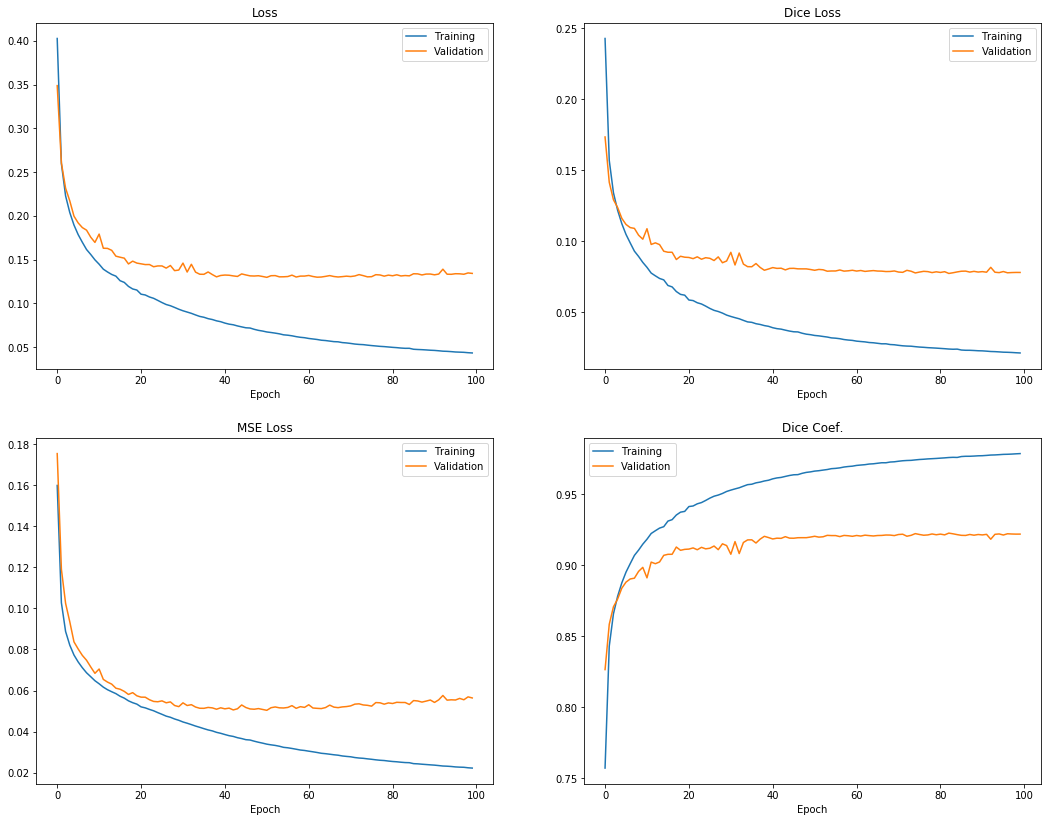

In [12]:
ad = history.history

f, ax = plt.subplots(2,2, figsize=(18,14))

ax[0,0].plot(ad['loss'], label='Training')
ax[0,0].plot(ad['val_loss'], label='Validation')
ax[0,0].set_title('Loss')
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend()

ax[0,1].plot(ad['output1_loss'], label='Training')
ax[0,1].plot(ad['val_output1_loss'], label='Validation')
ax[0,1].set_title('Dice Loss')
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend()

ax[1,0].plot(ad['output2_loss'], label='Training')
ax[1,0].plot(ad['val_output2_loss'], label='Validation')
ax[1,0].set_title('CE Loss')
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend()

ax[1,1].plot(ad['output1_dice_coef'], label='Training')
ax[1,1].plot(ad['val_output1_dice_coef'], label='Validation')
ax[1,1].set_title('Dice Coef.')
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend()

***

## Sample Predictions

### Small Dataset

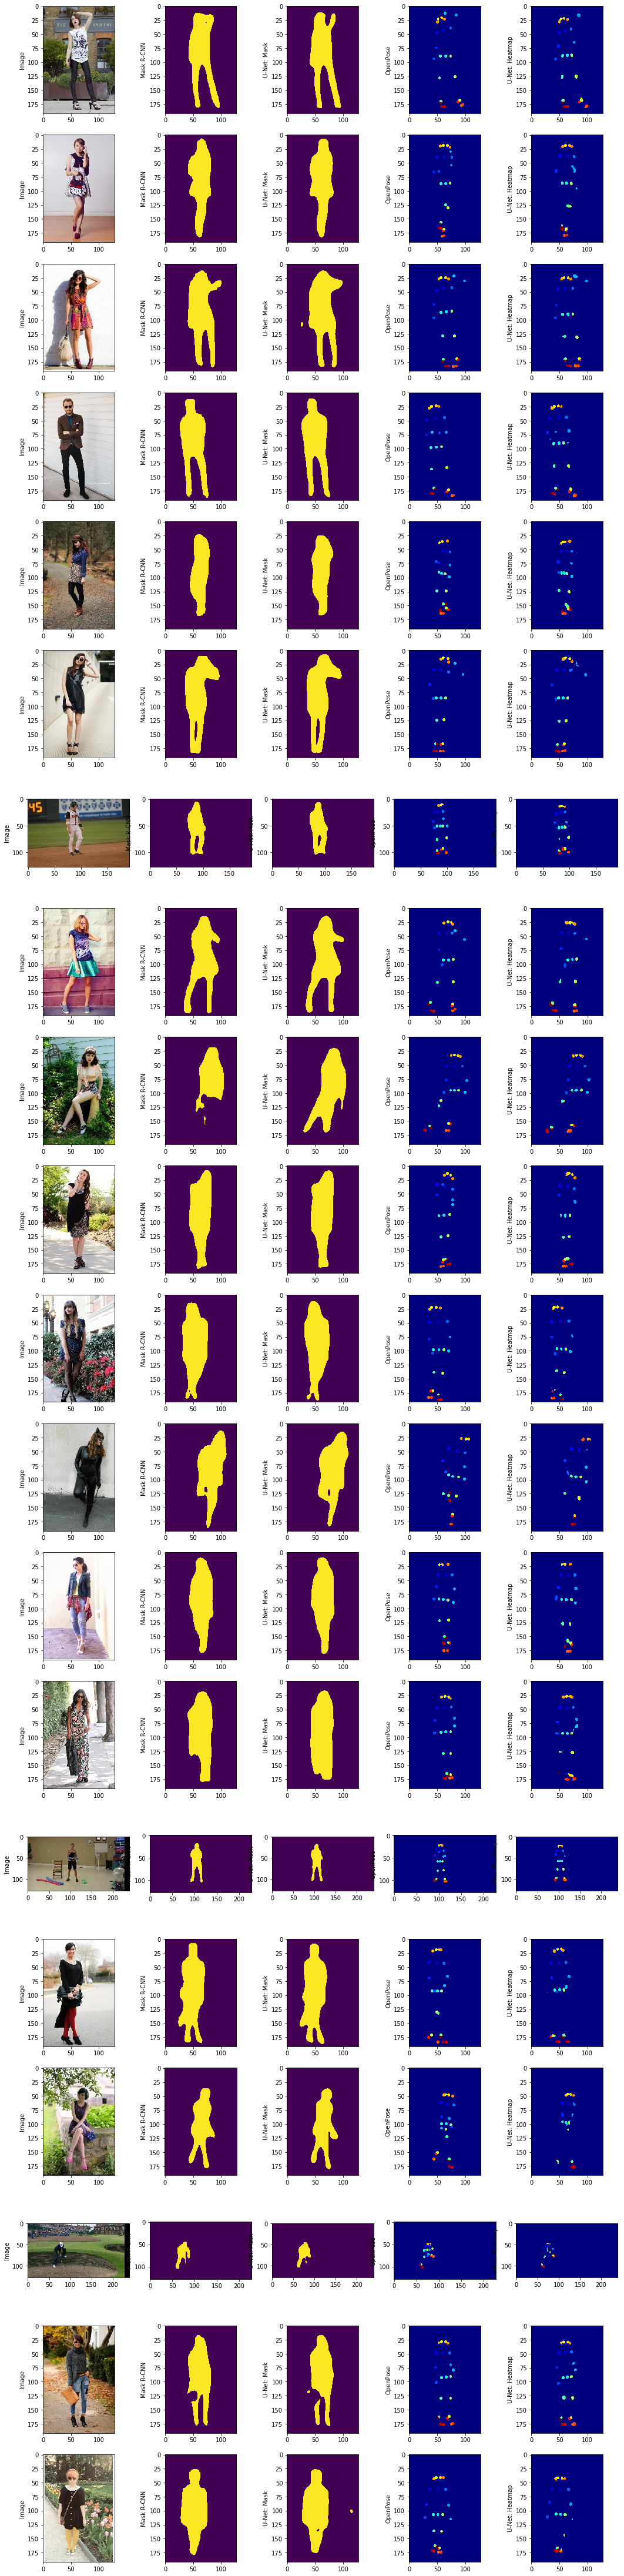

In [13]:
image_list = X_valid[40:60]

f, ax = plt.subplots(20,5, figsize=(18,80))
c_ = 0

for i in range(20):
    X_batch = cv2.cvtColor(cv2.imread(image_adr + images[image_list[c_]]), cv2.COLOR_BGR2RGB).astype('float32')
    X_batch /= 255

    r = X_batch.shape[0]
    c = X_batch.shape[1]
    r_pad = 0
    c_pad = 0

    while r % 16 != 0:
        r_pad += 1
        r += 1

    while c % 16 != 0:
        c_pad += 1
        c += 1

    X_batch = np.pad(X_batch, ((0, r_pad), (0, c_pad), (0, 0)), mode='constant', constant_values=0)
    ax[i,0].imshow(X_batch)
    X_batch = np.expand_dims(X_batch, axis=0)

    pred = model1.predict(X_batch)
    pred_1 = np.argmax(pred[0], axis=3)[0]
    pred_2 = np.argmax(pred[1], axis=3)

    ax[i,1].imshow(cv2.imread(mask_adr + images[image_list[c_]], 0))
    ax[i,2].imshow(pred_1)
    ax[i,3].imshow(np.load('SMALL_5K_HEATMAPSOFTMAX/' + images[image_list[c_]].replace('.jpg', '.npy'), 0), cmap='jet')
    ax[i,4].imshow(np.squeeze(pred_2), cmap='jet')

    c_ += 1

for j in range(20):
    _ = ax[j,0].set_ylabel('Image')
    _ = ax[j,1].set_ylabel('Mask R-CNN')
    _ = ax[j,2].set_ylabel('U-Net: Mask')
    _ = ax[j,3].set_ylabel('OpenPose')
    _ = ax[j,4].set_ylabel('U-Net: Heatmap')

In [8]:
joints = ['Background', 'Nose', 'Neck', 'Right Shoulder', 'Right Elbow', 'Right Wrist', 'Left Shoulder', 'Left Elbow',
         'Left Wrist', 'Middle Hip', 'Right Hip', 'Right Knee', 'Right Ankle', 'Left Hip', 'Left Knee', 'Left Ankle',
         'Right Eye', 'Left Eye', 'Right Ear', 'Left Ear', 'Left Big Toe', 'Left Small Toe', 'Left Heel', 'Right Big Toe',
         'Right Small Toe', 'Right Heel']

In [48]:
import matplotlib
import random
import json

def create_colors(n):
    
    cmap = matplotlib.cm.get_cmap('gist_ncar')
    colors = []

    for i in range(n):
        colors.append(cmap(random.random()))
        
    return colors

def draw_skeleton(mask_img, joint_pos, colors):
    
    skeleton = np.zeros(mask_img.shape + (3,))
    skeleton[(mask_img == 1),:] = 1. 
    
    neighbors = {
        0: [1,15,16], 1: [2,5,8], 2: [3], 3: [4], 5:[6], 6:[7], 8: [9,12], 
        9: [10], 10: [11], 11: [24,22],12: [13], 13: [14], 14: [21,19], 
        15:[17], 16:[18], 19:[20], 22:[23]
    }
    
    cl = 0
    
    for point in neighbors:
        if joint_pos[point] != (0,0):
            for neighbor in neighbors[point]:
                if joint_pos[neighbor] != (0,0):
                    cv2.line(skeleton, joint_pos[point][::-1], joint_pos[neighbor][::-1], colors[cl], 2)
                    cl += 1

    return skeleton

def openpose_joint_pos(j):
    
    x = []
    y = []
    
    joint_pos = []
    j = j.replace('.jpg', '_keypoints.json')

    for i, p in enumerate(json.load(open('SMALL_5K_OPENPOSE/' + j))['people'][0]['pose_keypoints_2d']):
        
        if i % 3 == 0:
            x.append(p)
        elif (i-1) % 3 == 0:
            y.append(p)
            
    impulses = np.zeros(cv2.imread('SMALL_5K_MASKS/' + j.replace('_keypoints.json', '.jpg')).shape[:2])
    
    y = np.floor(np.array(y)).astype('int')
    x = np.floor(np.array(x)).astype('int')
        
    for i in range(len(y)):
        if y[i] >= impulses.shape[0] or x[i] >= impulses.shape[1]:
            y[i] = 0
            x[i] = 0
            
        joint_pos.append((y[i], x[i]))
    
    return joint_pos

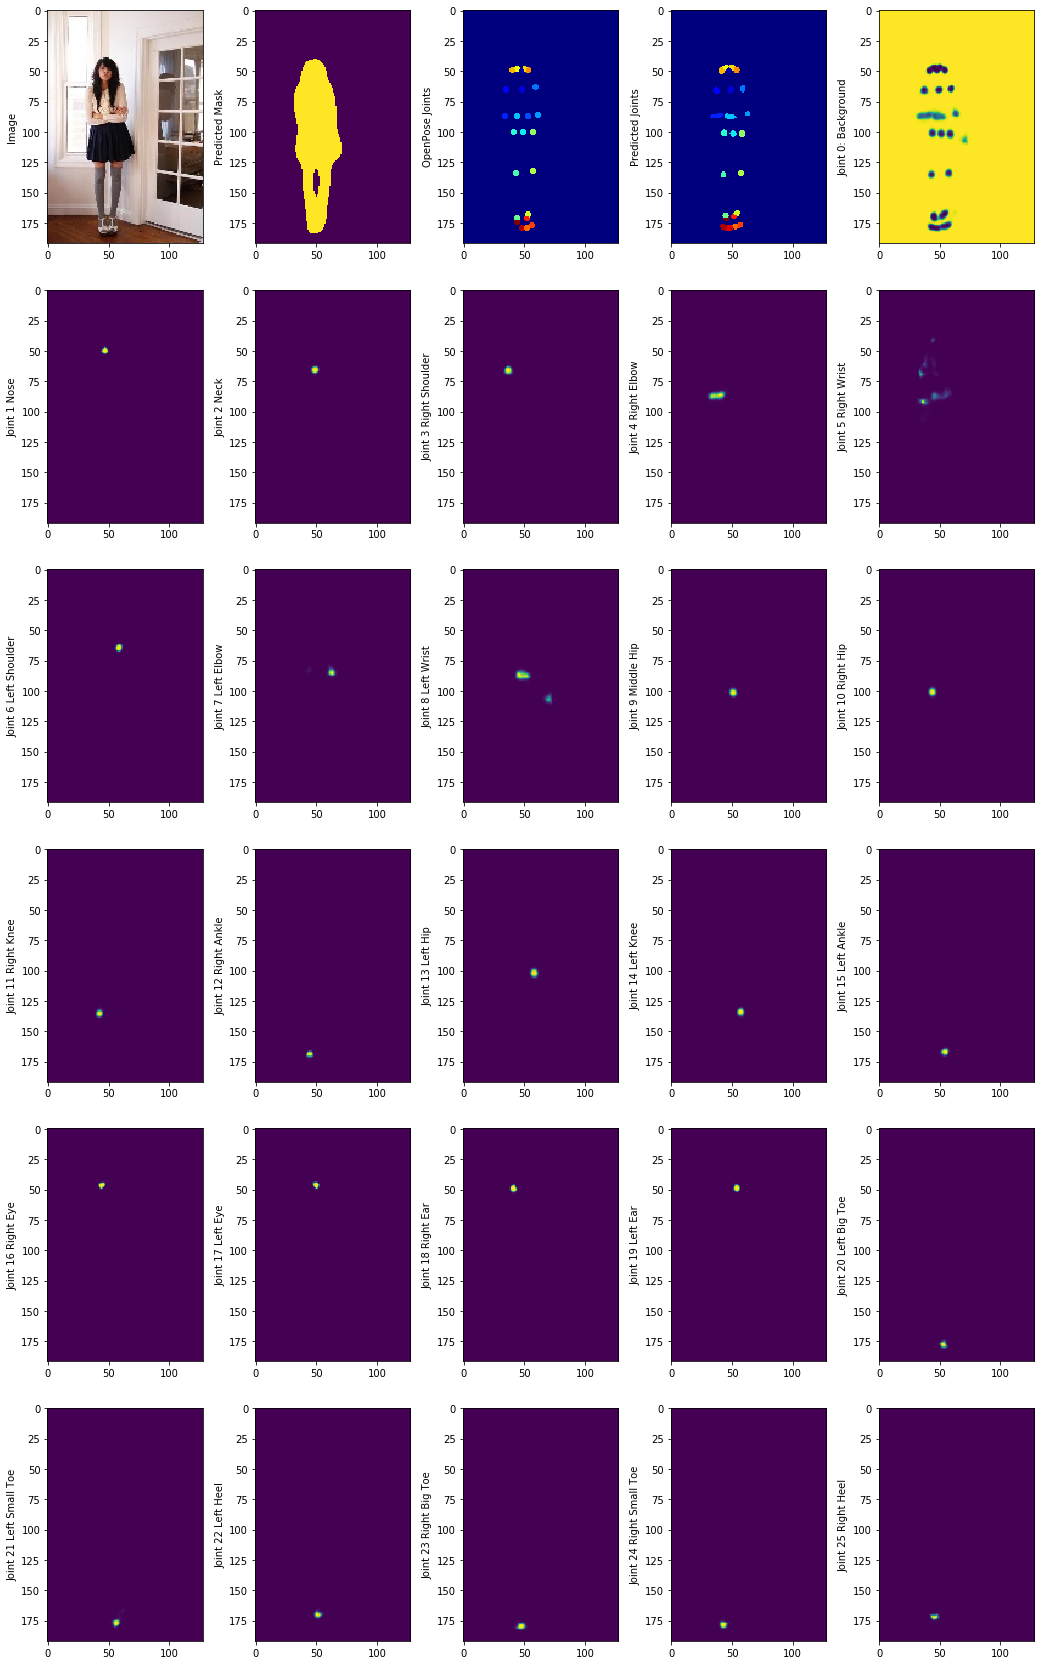

In [33]:
image_list = X_valid
f, ax = plt.subplots(6,5, figsize=(18,30))
c_ = np.random.randint(1000)

X_batch = cv2.cvtColor(cv2.imread(image_adr + images[image_list[c_]]), cv2.COLOR_BGR2RGB).astype('float32')
X_batch /= 255

r = X_batch.shape[0]
c = X_batch.shape[1]
r_pad = 0
c_pad = 0

while r % 16 != 0:
    r_pad += 1
    r += 1

while c % 16 != 0:
    c_pad += 1
    c += 1

X_batch = np.pad(X_batch, ((0, r_pad), (0, c_pad), (0, 0)), mode='constant', constant_values=0)

ax[0,0].imshow(X_batch)

X_batch = np.expand_dims(X_batch, axis=0)
pred = model.predict(X_batch)
pred_1 = np.argmax(pred[0], axis=3)[0]
pred_2 = np.squeeze(pred[1])

ax[0,1].imshow(pred_1)
ax[0,2].imshow(np.load('SMALL_5K_HEATMAPSOFTMAX/' + images[image_list[c_]].replace('.jpg', '.npy'), 0), cmap='jet')
ax[0,3].imshow(np.argmax(pred_2, axis=-1), cmap='jet')
ax[0,4].imshow(pred_2[:,:,0])

_ = ax[0,4].set_ylabel('Joint %d: %s' % (0, joints[0]))
ct_ = 1

joint_pos = []

for i in range(1,6):
    for j in range(5):
        ax[i,j].imshow(pred_2[:,:,ct_])
        _ = ax[i,j].set_ylabel('Joint %d %s' % (ct_, joints[ct_]))
        joint_pos.append(np.unravel_index(pred_2[:,:,ct_].argmax(), pred_2[:,:,ct_].shape))
        ct_ += 1
        
_ = ax[0,0].set_ylabel('Image')
_ = ax[0,1].set_ylabel('Predicted Mask')
_ = ax[0,2].set_ylabel('OpenPose Joints')
_ = ax[0,3].set_ylabel('Predicted Joints')

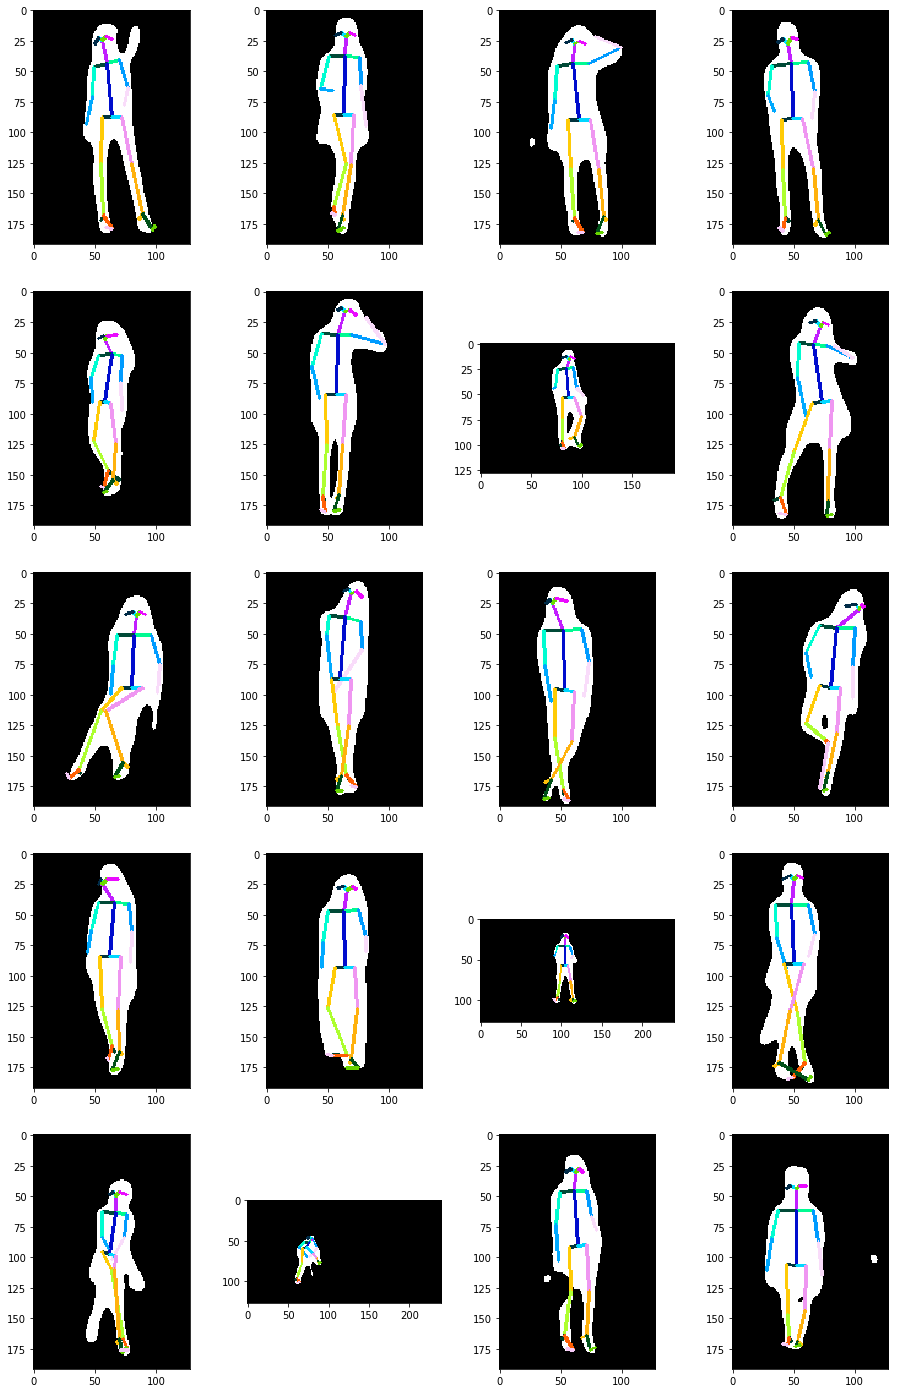

In [182]:
image_list = X_valid[40:60]

f, ax = plt.subplots(5,4, figsize=(16,25))
c_ = 0
colors = create_colors(30)

for x in range(5):
    for y in range(4):
        X_batch = cv2.cvtColor(cv2.imread(image_adr + images[image_list[c_]]), cv2.COLOR_BGR2RGB).astype('float32')
        X_batch /= 255

        r = X_batch.shape[0]
        c = X_batch.shape[1]
        r_pad = 0
        c_pad = 0

        while r % 16 != 0:
            r_pad += 1
            r += 1

        while c % 16 != 0:
            c_pad += 1
            c += 1

        X_batch = np.pad(X_batch, ((0, r_pad), (0, c_pad), (0, 0)), mode='constant', constant_values=0)
        X_batch = np.expand_dims(X_batch, axis=0)
        
        pred = model.predict(X_batch)
        pred_1 = np.argmax(pred[0], axis=3)[0]
        pred_2 = np.squeeze(pred[1])

        ct_ = 1
        
        joint_pos = []

        for i in range(1,6):
            for j in range(5):
                joint_pos.append(np.unravel_index(pred_2[:,:,ct_].argmax(), pred_2[:,:,ct_].shape))
                ct_ += 1
    
        ax[x,y].imshow(draw_skeleton(pred_1, joint_pos, colors))

        c_ += 1

## 30 Images w/ Real Mask/Skeletons and Predicted Mask/Skeletons

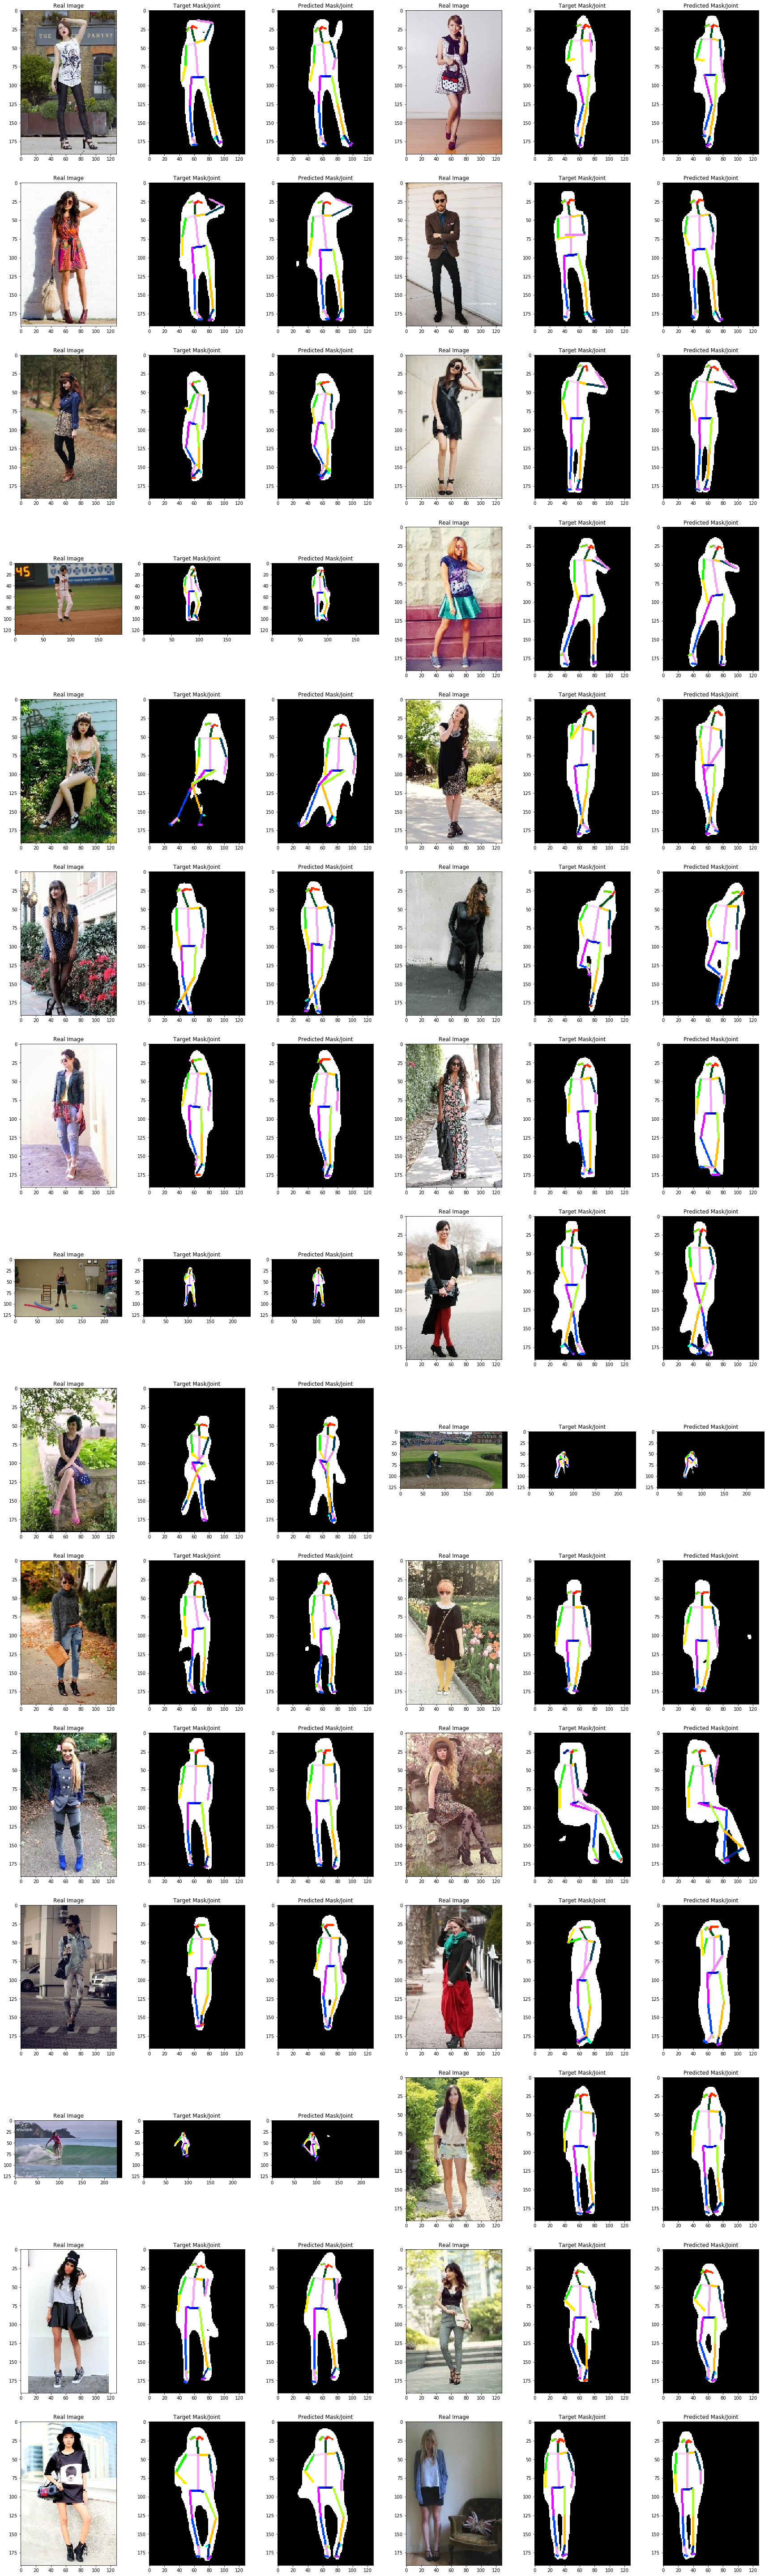

In [53]:
image_list = X_valid[40:70]

f, ax = plt.subplots(15,6, figsize=(30,105))
c_ = 0
colors = create_colors(30)

for x in range(15):
    for y in range(2):
        X_batch = cv2.cvtColor(cv2.imread(image_adr + images[image_list[c_]]), cv2.COLOR_BGR2RGB).astype('float32')
        X_batch /= 255
        X_mask = cv2.imread(mask_adr + images[image_list[c_]], 0)
        X_mask = (X_mask > 200).astype('int')
        
        r = X_batch.shape[0]
        c = X_batch.shape[1]
        r_pad = 0
        c_pad = 0

        while r % 16 != 0:
            r_pad += 1
            r += 1

        while c % 16 != 0:
            c_pad += 1
            c += 1

        X_batch = np.pad(X_batch, ((0, r_pad), (0, c_pad), (0, 0)), mode='constant', constant_values=0)
        X_mask = np.pad(X_mask, ((0, r_pad), (0, c_pad)), mode='constant', constant_values=0)
        
        X_batch = np.expand_dims(X_batch, axis=0)
        
        pred = model.predict(X_batch)
        pred_1 = np.argmax(pred[0], axis=3)[0]
        pred_2 = np.squeeze(pred[1])

        ct_ = 1
        
        joint_pos = []

        for i in range(1,6):
            for j in range(5):
                joint_pos.append(np.unravel_index(pred_2[:,:,ct_].argmax(), pred_2[:,:,ct_].shape))
                ct_ += 1
                
        ax[x,y*3].imshow(np.squeeze(X_batch))
        ax[x,y*3+1].imshow(draw_skeleton(X_mask, openpose_joint_pos(images[image_list[c_]]), colors))
        ax[x,y*3+2].imshow(draw_skeleton(pred_1, joint_pos, colors))
        
        ax[x,y*3].set_title('Real Image')
        ax[x,y*3+1].set_title('Target Mask/Joint')
        ax[x,y*3+2].set_title('Predicted Mask/Joint')

        c_ += 1